# Weather models : 2D parameters

The aim of this notebook is to indicate how to read the 2D data from weather models.
There are 2 weather models:
* a fine-mesh french weather model called 'AROME' (spatial resolution of 0.025°)
* a large-mesh french weather model called '{modele}' (spatial resolution of 0.1°)

Per model and day, you have the model run of 00h with range forecasts from 00h to 24h. The time step is 1h.

Here are the different weather parameters:

* at 2m: temperature (in K), dew point temperature** (in K) and relative humidity (in %)
* at 10m: wind speed (in m.s<sup>-1</sup>), wind direction (in degrees), U and V wind components*** (in m.s<sup>-1</sup>)
* at the sea level: mean sea level pressure (in Pa)
* at the ground level: total precipitation (in kg m<sup>-2</sup> which is equivalent to mm) **since the beginning of the model run**

For more information about data, cf [documentation](https://meteofrance.github.io/meteonet/english/data/weather-models/).

** : temperature for which it is needed to refresh an air volume at constant pressure and humidity to become it saturated (i.e. condensation temperature)

*** : horizontal wind speed components, U : from west to east and V : from south to north. 

# Objective

Open Weather Forecast data base and interpolate parameter values for the stations studies

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import multiprocess
from functools import partial

import os
os.chdir("F:/Defi_IA/data")

import warnings
warnings.filterwarnings('ignore')

from pyproj import Proj, transform
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:2154')

modele = 'arpege'

In [2]:
# Load the datasets
df_stations = pd.read_csv("Other/stations_coordinates.csv",
        dtype = {"number_sta": int}         
    ).rename(
        columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"})

df_stations['coord_x'], df_stations['coord_y'] = transform(inProj, outProj, df_stations.longitude.to_numpy(), df_stations.latitude.to_numpy())
df_stations.drop(['longitude', 'latitude', 'height'], axis=1, inplace=True)

df_stations_hour = pd.merge(df_stations, pd.DataFrame({'hour':range(24)}), how="cross")
df_stations.tail()

,station,coord_x,coord_y
320,86137003,479679.664525,6.663467e+06
321,86165005,534180.278397,6.592494e+06
322,86273001,549757.726637,6.597865e+06
323,91200002,625645.913689,6.825559e+06
324,95690001,614643.112554,6.890430e+06


In [4]:
# Test
features_selected = ['ws', 'p3031', 'u10', 'v10', 't2m', 'd2m', 'r', 'tp', 'msl']

def processing_data_train(df_modele_train):
    from pyproj import Proj, transform
    from pandas import Timedelta
    from numpy import datetime64
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:2154')
    first_date = datetime64("2016-01-01T00:00")

    df_modele_train = df_modele_train.sort_values(['longitude', 'latitude', 'valid_time']).drop(['time'], axis=1).reset_index()
    df_modele_train['coord_x'], df_modele_train['coord_y']  = transform(inProj, outProj, df_modele_train.longitude.to_numpy(), df_modele_train.latitude.to_numpy())
    df_modele_train['day_index'] = ((df_modele_train["valid_time"] - first_date) / Timedelta(days=1)).astype(int)
    df_modele_train["hour"] = df_modele_train["valid_time"].dt.hour.astype(int)
    df_modele_train.drop(['longitude', 'latitude', 'valid_time'], axis=1, inplace=True)
    df_modele_train['tp'] = df_modele_train.groupby(['coord_x', 'coord_y'])['tp'].shift(-1)
    df_modele_train.drop_duplicates(['coord_x', 'coord_y', 'hour'], keep='first', inplace=True)

    return df_modele_train

def processing_data_test(df_modele_test):
    from pyproj import Proj, transform
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:2154')

    df_modele_test = df_modele_test.sort_values(['longitude', 'latitude', 'Id']).drop(['time'], axis=1).reset_index()
    df_modele_test['coord_x'], df_modele_test['coord_y']  = transform(inProj, outProj, df_modele_test.longitude.to_numpy(), df_modele_test.latitude.to_numpy())
    df_modele_test['day_index'] = df_modele_test.Id.str.split('_').str[0].astype(int)
    df_modele_test['hour'] = df_modele_test.Id.str.split('_').str[1].astype(int)
    df_modele_test.drop(['longitude', 'latitude', 'Id'], axis=1, inplace=True)
    df_modele_test['tp'] = df_modele_test.groupby(['coord_x', 'coord_y'])['tp'].shift(-1)
    df_modele_test = df_modele_test[df_modele_test.hour != 24] #On retire l'heure de fin
    
    return df_modele_test

def interpolate_data(file_path, df_stations, process_fct, features):
    from scipy.interpolate import griddata
    from xarray import open_dataset
    from pandas import concat

    def agg_interpolate(key, df_points, features):
        # A function that realize the interpolation of the model and with the staion coordinate
        index, group = key
        df_out = df_points[['station', 'coord_x', 'coord_y']].copy()
        for feature in features:
            df_out[feature] = griddata((group.coord_x, group.coord_y), group[feature], (df_out.coord_x, df_out.coord_y), method='cubic')
            df_out.loc[df_out[feature].isna(), feature] = griddata((group.coord_x, group.coord_y), group[feature], (df_out[df_out[feature].isna()].coord_x, df_out[df_out[feature].isna()].coord_y), method='nearest')
        
        return df_out.assign(day_index=index[0], hour=index[1]).drop(['coord_x', 'coord_y'], axis=1)

    df_modele = process_fct(open_dataset(file_path)[features].to_dataframe())

    df_buffer = concat([agg_interpolate(key, df_stations, features) for key in df_modele.groupby(['day_index', 'hour'])])
    df_buffer.to_csv(f"F:/Defi_IA/data/Train/X_forecast/Features_arome/features_{df_modele['day_index'].unique()[0]}.csv", index=False)

    print(f"File {file_path} finish. Row : {df_buffer.shape[0]}")
    return df_buffer


### Train

In [5]:

#list_file = [f"F:/Defi_IA/data/Train/X_forecast/2D_{modele}_{year}/{file}" for year in ['2016', '2017'] for file in os.listdir(f'Train/X_forecast/2D_{modele}_{year}')]
list_file = [f"F:/Defi_IA/data/Train/X_forecast/other/{file}" for year in ['2016', '2017'] for file in os.listdir(f'Train/X_forecast/other')]

with multiprocess.Pool(processes=12) as p:
    df_new_feature_train=pd.concat(p.map(partial(interpolate_data, df_stations=df_stations, process_fct=processing_data_train, features=features_selected), list_file))

#df_new_feature_train = pd.concat([interpolate_data(file, df_stations, processing_data_train, features_selected) for file in list_file])

df_new_feature_train = df_new_feature_train.groupby(['station', 'day_index', 'hour']).mean().reset_index() # In case of duplicates
df_new_feature_train.to_csv(f"Dataset/features_forecast_train_{modele}.csv", index=False)
df_new_feature_train.head()

,station,day_index,hour,ws,p3031,u10,v10,t2m,d2m,r,tp,msl
0,14047002,456,0,5.415024,210.184322,2.718438,4.687232,282.958250,279.178903,77.304192,5.296124e-28,101060.085145
1,14047002,456,1,4.568080,199.097008,1.496264,4.315923,282.058823,279.197573,82.240547,-1.054290e-23,101039.339113
2,14047002,456,2,5.218267,203.937312,2.111573,4.769165,281.661344,279.411559,85.744873,4.208430e-14,101058.105645
3,14047002,456,3,5.496965,207.256352,2.512019,4.891277,281.537108,279.403954,86.422770,-6.526631e-13,101039.899918
4,14047002,456,4,4.867220,200.783628,1.725531,4.555268,281.663873,278.958876,83.085596,-6.527583e-13,101012.309775


### Test

In [ ]:

list_file = [f"F:/Defi_IA/data/Test/X_forecast/2D_{modele}/{file}" for file in os.listdir(f'Test/X_forecast/2D_{modele}')]

with multiprocess.Pool(processes=10) as p:
    df_new_feature_test=pd.concat(p.map(partial(interpolate_data, df_stations=df_stations, process_fct=processing_data_test, features=features_selected), list_file))

#df_new_feature_test = pd.concat([interpolate_data(file, df_stations, processing_data_test, features_selected) for file in list_file])

df_new_feature_test = df_new_feature_test.groupby(['station', 'day_index', 'hour']).mean().reset_index() # In case of duplicates
df_new_feature_test.to_csv(f"Dataset/features_forecast_test_{modele}.csv", index=False)
df_new_feature_test.head()

,station,day_index,hour,ws,p3031,u10,v10,t2m,d2m,r,tp,msl
0,14047002,0,0,4.428375,189.732796,0.743604,4.365963,277.357007,276.449967,93.813374,0.000003,102186.837994
1,14047002,0,1,4.438495,190.516263,0.809133,4.361863,277.213567,276.341751,94.031055,0.000052,102189.725263
2,14047002,0,2,4.841047,191.655703,0.974549,4.742449,277.234170,276.263917,93.379562,0.000114,102167.901495
3,14047002,0,3,5.184823,195.696381,1.401388,4.993907,277.353518,276.189772,92.114141,0.000013,102132.496980
4,14047002,0,4,4.943566,196.697050,1.417841,4.732628,277.349078,276.114940,91.645733,0.000005,102100.175760


### Merge

In [ ]:
df_new_feature = pd.concat([df_new_feature_train.assign(test=False), df_new_feature_test.assign(test=True)])
df_new_feature.to_csv(f"Dataset/features_forecast_{modele}.csv", index=False)
df_new_feature.head()

,station,day_index,hour,ws,p3031,u10,v10,t2m,d2m,r,tp,msl,test
0,14047002,0,0,3.452009,205.463839,1.480413,3.119770,278.916352,278.017919,93.930851,0.000009,102277.323401,False
1,14047002,0,1,2.823987,205.330340,1.211047,2.552746,278.274454,277.517979,94.816988,0.000037,102312.407032,False
2,14047002,0,2,2.065804,179.742845,-0.011528,2.074044,277.415496,276.887249,96.363128,0.000078,102322.366674,False
3,14047002,0,3,1.899316,171.976215,-0.300709,1.888490,276.714877,276.314645,97.193587,0.000341,102356.752744,False
4,14047002,0,4,2.065611,149.479150,-1.072402,1.789859,276.156290,275.803757,97.528195,0.000750,102275.589211,False


### Missing Arome & Arpege file issue

In [5]:
features_selected = ['ws', 'p3031', 'u10', 'v10', 't2m', 'd2m', 'r', 'tp', 'msl']

df_full_index = pd.read_csv("Dataset/Full_index.csv")[['station', 'test', 'day_index', 'hour']]

df_new_feature_arpege = pd.merge(df_full_index, pd.read_csv(f"Dataset/features_forecast_arpege.csv"), on=['station', 'test', 'day_index', 'hour'], how="left")
df_new_feature_train_arome = pd.merge(df_full_index, pd.read_csv(f"Dataset/features_forecast_train_arome_missing.csv").assign(test=False), on=['station', 'test', 'day_index', 'hour'], how="left")

for feature in features_selected:
    df_new_feature_arpege[feature] = np.where(df_new_feature_arpege[feature].isna(), df_new_feature_train_arome[feature], df_new_feature_arpege[feature])

df_new_feature_arpege.to_csv("Dataset/features_forecast_final.csv", index=False)
df_new_feature_arpege.head()

,station,test,day_index,hour,ws,p3031,u10,v10,t2m,d2m,r,tp,msl
0,14047002,False,0,0,3.452009,205.463839,1.480413,3.119770,278.916352,278.017919,93.930851,0.000009,102277.323401
1,14047002,False,0,1,2.823987,205.330340,1.211047,2.552746,278.274454,277.517979,94.816988,0.000037,102312.407032
2,14047002,False,0,2,2.065804,179.742845,-0.011528,2.074044,277.415496,276.887249,96.363128,0.000078,102322.366674
3,14047002,False,0,3,1.899316,171.976215,-0.300709,1.888490,276.714877,276.314645,97.193587,0.000341,102356.752744
4,14047002,False,0,4,2.065611,149.479150,-1.072402,1.789859,276.156290,275.803757,97.528195,0.000750,102275.589211


In [9]:
df_new_feature_arpege[df_new_feature_arpege.tp.isna()]

,station,test,day_index,hour,ws,p3031,u10,v10,t2m,d2m,r,tp,msl
11520,14047002,False,480,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11521,14047002,False,480,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11522,14047002,False,480,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11523,14047002,False,480,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11524,14047002,False,480,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525289,95690001,True,148,9,0.130272,244.441465,0.106711,0.116836,272.586606,272.534172,99.554835,NaN,103095.570989
8525313,95690001,True,205,9,1.153702,280.645371,1.140582,-0.208825,273.084004,273.049040,99.709186,NaN,102518.534665
8525337,95690001,True,346,9,3.658424,233.289709,2.933577,2.188795,279.479051,279.265923,98.530682,NaN,101850.790697
8525361,95690001,True,234,9,12.007876,299.599267,10.443341,-5.934208,281.437393,278.496780,81.726143,NaN,100412.973685


<AxesSubplot:>

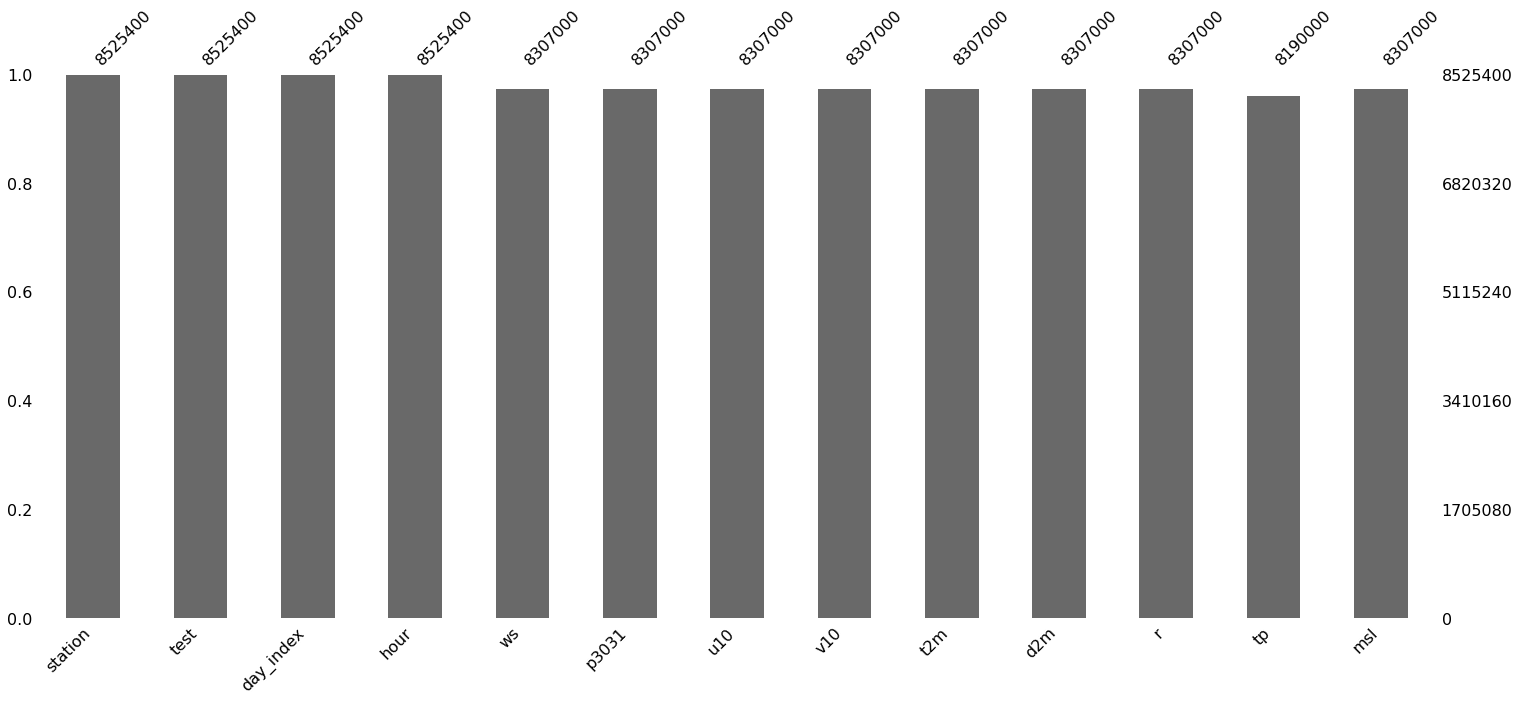

In [7]:
import missingno as msno
msno.bar(df_new_feature_arpege)

### Analyses

<AxesSubplot:xlabel='test,day_index,hour'>

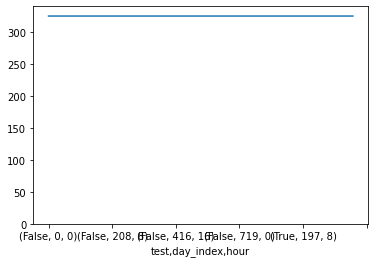

In [ ]:
df_new_feature.groupby(['test', 'day_index', 'hour']).msl.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))

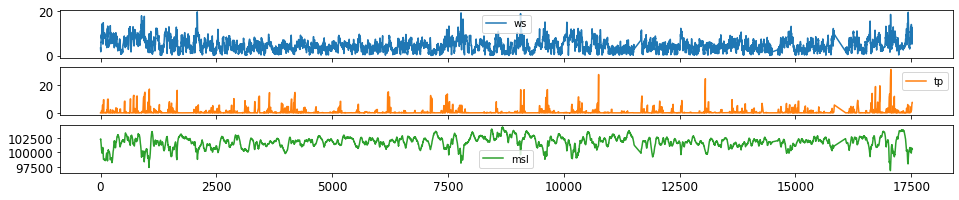

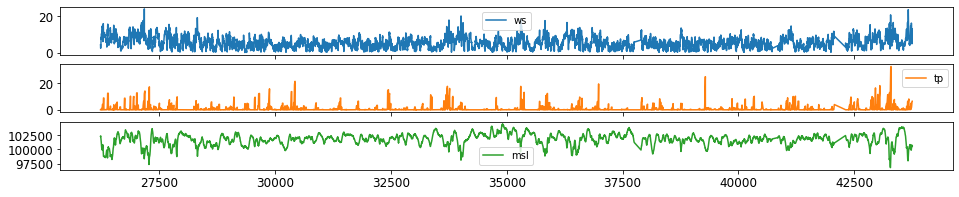

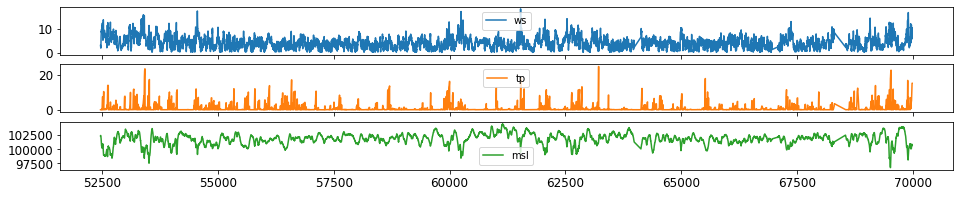

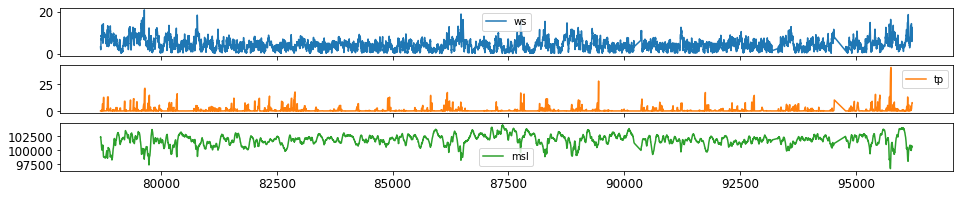

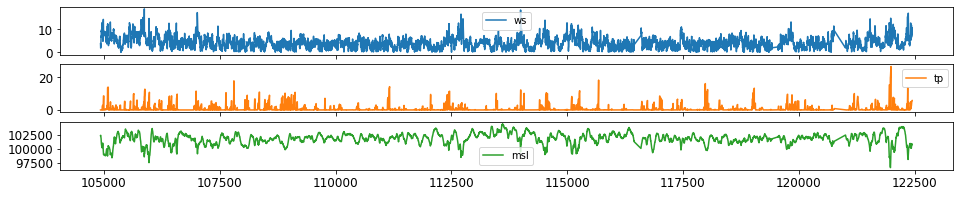

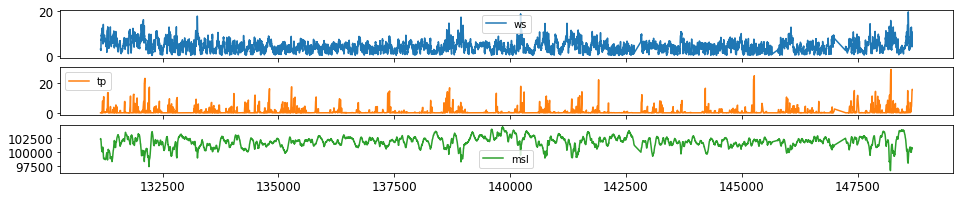

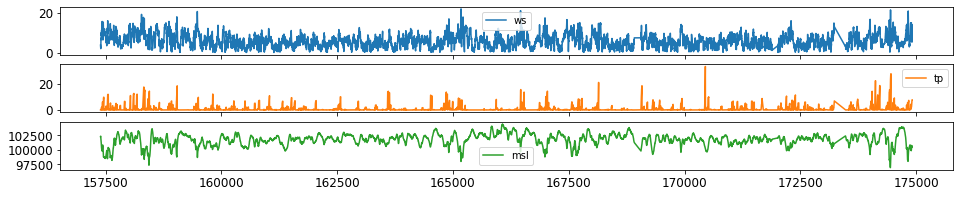

In [22]:
for i, (index, df_iter) in enumerate(df_new_feature_arpege[~df_new_feature_arpege.test].groupby('station')):
    df_iter[['ws', 'tp', 'msl']].interpolate().plot(subplots=True, fontsize=12, figsize=(16, 3))
    if i>5:
        break